# **Model Training & Evaluation (Cross-Validation & Validation Split)**

In [1]:
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import (Input, Layer, Embedding, Bidirectional,
                                     LSTM, Dense, Dropout, Conv1D, GlobalAveragePooling1D,
                                     LayerNormalization, MultiHeadAttention)
from tensorflow.keras.models import Model, Sequential
from keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

SEED = 42
tf.random.set_seed(SEED)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

In [4]:
# load the preprocessed datasets
X_train, X_test, y_train, y_test = joblib.load('/content/drive/MyDrive/fake_news/data/preprocessed_data.pkl')


In [5]:
MAX_LEN = 256
VOCAB_SIZE = 20000
EMBED_DIM = 64

## Cross-Validation Approach

In [ ]:
def build_model():
  inputs = Input(shape = (MAX_LEN,), dtype = "int64")
  x = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_DIM)(inputs)
  x = Bidirectional(LSTM(32, return_sequences = True))(x)
  x = TransformerBlock(EMBED_DIM, 4, 128)(x)
  x = Conv1D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(x)
  x = GlobalAveragePooling1D()(x)
  x = Dense(32, activation = "relu")(x)
  x = Dropout(0.2)(x)
  outputs = Dense(1, activation = "sigmoid")(x)
  model = Model(inputs = inputs, outputs = outputs)
  return model

In [ ]:
fold = 1
scores = []

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

for train_idx, val_idx in skf.split(X_train, y_train):
  X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
  y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

  model = build_model()
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
  model.compile(optimizer = optimizer,
                loss = "binary_crossentropy",
                metrics = ["accuracy"])
  model.fit(X_train_fold,
            y_train_fold,
            validation_data = (X_val_fold, y_val_fold),
            epochs = 10,
            batch_size = 256,
            verbose = 1)

  loss, acc = model.evaluate(X_val_fold, y_val_fold, verbose = 0)
  scores.append(acc)
  print(f"Fold {fold} Accuracy: {acc}")
  fold += 1

print(f"Mean Accuracy: {np.mean(scores)}")

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - accuracy: 0.5919 - loss: 0.6705 - val_accuracy: 0.8236 - val_loss: 0.5806
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.8100 - loss: 0.5478 - val_accuracy: 0.8904 - val_loss: 0.4192
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.8867 - loss: 0.3959 - val_accuracy: 0.9133 - val_loss: 0.2899
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.9203 - loss: 0.2822 - val_accuracy: 0.9343 - val_loss: 0.2123
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.9422 - loss: 0.2121 - val_accuracy: 0.9568 - val_loss: 0.1666
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.9545 - loss: 0.1681 - val_accuracy: 0.9649 - val_loss: 0.1350
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9637 - loss: 0.1357 - val_accuracy: 0.9685 - val_loss: 0.1139
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.9707 - loss: 0.1116 - val_accu

## Validation-Split Approach

In [6]:
inputs = Input(shape = (MAX_LEN,), dtype = "int64")
x = Embedding(input_dim = VOCAB_SIZE, output_dim = EMBED_DIM)(inputs)
x = Bidirectional(LSTM(32, return_sequences = True))(x)
x = TransformerBlock(EMBED_DIM, 4, 128)(x)
x = Conv1D(filters = 64, kernel_size = 3, padding = "same", activation = "relu")(x)
x = GlobalAveragePooling1D()(x)
x = Dense(32, activation = "relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation = "sigmoid")(x)
model_vs = Model(inputs = inputs, outputs = outputs)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5)
model_vs.compile(optimizer = optimizer,
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [8]:
model_vs.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 256, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 256, 64)        │        83,200 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 256, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,402,497 (5.35 MB)

 Trainable params: 1,402,497 (5.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model_vs.fit(X_train, y_train, batch_size = 256, epochs = 10, validation_split = 0.2)

Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 22s 118ms/step - accuracy: 0.5592 - loss: 0.6885 - val_accuracy: 0.8163 - val_loss: 0.6117
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.7554 - loss: 0.5938 - val_accuracy: 0.8826 - val_loss: 0.4561
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.8749 - loss: 0.4299 - val_accuracy: 0.9182 - val_loss: 0.3028
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 111ms/step - accuracy: 0.9202 - loss: 0.2972 - val_accuracy: 0.9389 - val_loss: 0.2169
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9417 - loss: 0.2203 - val_accuracy: 0.9583 - val_loss: 0.1651
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.9555 - loss: 0.1721 - val_accuracy: 0.9659 - val_loss: 0.1325
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9637 - loss: 0.1367 - val_accuracy: 0.9712 - val_loss: 0.1098
Epoch 8/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 113ms/step - accuracy: 0.9694 - loss: 0.1149 - val_accu

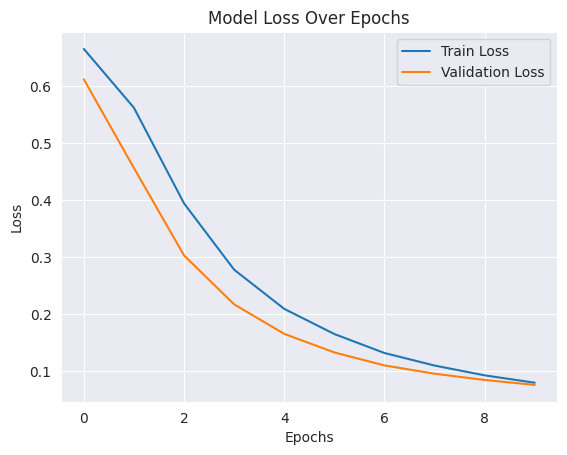

In [10]:
sns.set_style("darkgrid")
sns.lineplot(history.history['loss'], label = "Train Loss")
sns.lineplot(history.history['val_loss'], label = "Validation Loss")
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

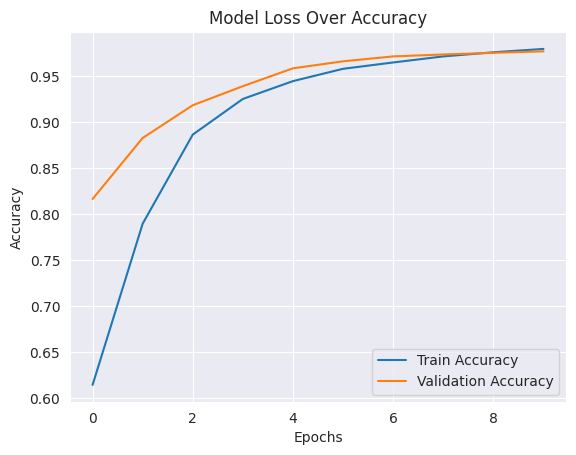

In [11]:
sns.set_style("darkgrid")
sns.lineplot(history.history['accuracy'], label = "Train Accuracy")
sns.lineplot(history.history['val_accuracy'], label = "Validation Accuracy")
plt.title("Model Loss Over Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [13]:
y_pred_prob = model_vs.predict(X_test)

242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step


In [14]:
y_pred_prob

array([[0.00116763],
       [0.00226915],
       [0.00872423],
       ...,
       [0.96369165],
       [0.00202258],
       [0.98584205]], dtype=float32)

In [15]:
y_pred_class = (y_pred_prob >= 0.5).astype(int)

In [16]:
y_pred_class

array([[0],
       [0],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [17]:
print(classification_report(y_test, y_pred_class, target_names = ["FAKE", "REAL"]))

              precision    recall  f1-score   support

        FAKE       0.98      0.97      0.97      3486
        REAL       0.97      0.98      0.98      4244

    accuracy                           0.98      7730
   macro avg       0.98      0.97      0.97      7730
weighted avg       0.98      0.98      0.98      7730



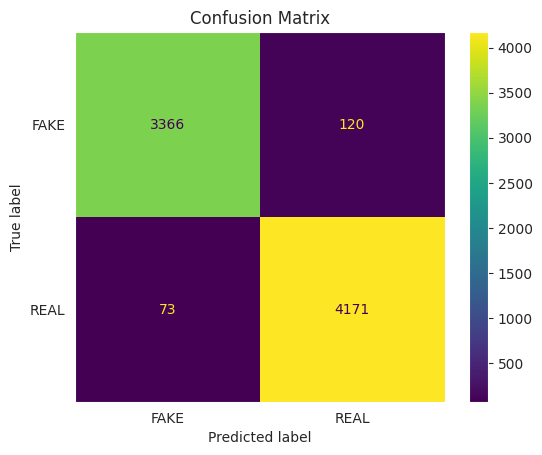

In [18]:
cm = confusion_matrix(y_test, y_pred_class)

disp = ConfusionMatrixDisplay(cm, display_labels = ["FAKE", "REAL"])
disp.plot()
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

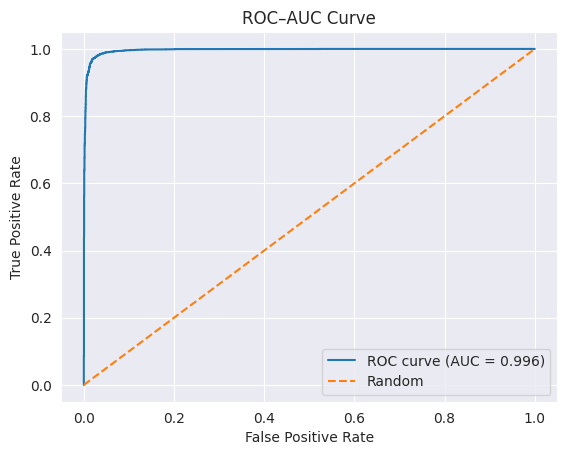

In [19]:
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend(loc="lower right")
plt.show()

In [20]:
model_vs.save("/content/drive/MyDrive/fake_news/model.keras")